<a href="https://colab.research.google.com/github/asahedev/ds-ml-guides/blob/main/missing_data_guide_jpynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Missing Data Handling - Complete Guide

This notebook demonstrates different strategies for handling missing values in datasets. We'll compare their performance so you can choose the best approach for your projects.

**Business Impact:** Choosing the right missing data strategy can significantly improve model accuracy and save development time.

## Setup: Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Step 1: Create Sample Dataset with Missing Values

For demonstration, we're creating a realistic dataset similar to what we might encounter in production. The dataset simulates a loan application scenario with features like age, income, credit score, etc.

**In practice, you would load your actual data here using:**
```python
df = pd.read_csv('your_data.csv')
```

In [ ]:
print("="*60)
print("CREATING SAMPLE DATASET")
print("="*60)

np.random.seed(42)
n_samples = 1000

# Create a dataset with correlated features (like real-world data)
data = {
    'age': np.random.randint(18, 70, n_samples),
    'income': np.random.randint(30000, 150000, n_samples),
    'credit_score': np.random.randint(300, 850, n_samples),
    'years_employed': np.random.randint(0, 40, n_samples),
    'debt': np.random.randint(0, 100000, n_samples)
}

df = pd.DataFrame(data)

# Create target variable (e.g., loan approval amount)
df['loan_amount'] = (
    df['income'] * 0.3 +
    df['credit_score'] * 50 -
    df['debt'] * 0.2 +
    np.random.normal(0, 5000, n_samples)
)

# Introduce missing values (simulating real-world scenario)
# About 15-20% missing in some columns
missing_mask_income = np.random.random(n_samples) < 0.15
missing_mask_credit = np.random.random(n_samples) < 0.20
missing_mask_employed = np.random.random(n_samples) < 0.10

df.loc[missing_mask_income, 'income'] = np.nan
df.loc[missing_mask_credit, 'credit_score'] = np.nan
df.loc[missing_mask_employed, 'years_employed'] = np.nan

print(f"\nDataset created with {len(df)} rows and {len(df.columns)-1} features")
print(f"\nMissing values per column:")
print(df.isnull().sum())
print(f"\nPercentage missing:")
print((df.isnull().sum() / len(df) * 100).round(2))

CREATING SAMPLE DATASET

Dataset created with 1000 rows and 5 features

Missing values per column:
age                 0
income            167
credit_score      196
years_employed     98
debt                0
loan_amount         0
dtype: int64

Percentage missing:
age                0.0
income            16.7
credit_score      19.6
years_employed     9.8
debt               0.0
loan_amount        0.0
dtype: float64


## Step 2: Split Data into Training and Validation Sets

**Critical:** We always split BEFORE handling missing values to avoid data leakage. This ensures our validation set truly represents unseen data.

In [ ]:
y = df['loan_amount']
X = df.drop(['loan_amount'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train)} rows")
print(f"Validation set: {len(X_valid)} rows")

Training set: 800 rows
Validation set: 200 rows


## Helper Function: Evaluate Model Performance

This function trains a Random Forest model and calculates Mean Absolute Error (MAE). Lower MAE = better performance.

In [ ]:
def evaluate_approach(X_train, X_valid, y_train, y_valid, approach_name):
    """
    Trains a model and returns the MAE (Mean Absolute Error).
    Lower MAE = better performance.
    """
    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, predictions)
    return mae

---

# Method 1: Drop Columns with Missing Values

**Strategy:** Remove any column that has at least one missing value

**Best for:** When columns have >60% missing or aren't critical features

**Pros:** Simple, fast, no assumptions about missing data

**Cons:** Loses potentially valuable information

In [ ]:
print("="*60)
print("METHOD 1: DROP COLUMNS WITH MISSING VALUES")
print("="*60)

cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]
print(f"\nColumns to drop: {cols_with_missing}")

reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print(f"Features remaining: {reduced_X_train.shape[1]} out of {X_train.shape[1]}")

mae_drop_cols = evaluate_approach(reduced_X_train, reduced_X_valid, y_train, y_valid, "Drop Columns")
print(f"\nPerformance (MAE): ${mae_drop_cols:,.2f}")
print("\n⚠️  Note: We lost potentially useful information by dropping these columns")

METHOD 1: DROP COLUMNS WITH MISSING VALUES

Columns to drop: ['income', 'credit_score', 'years_employed']
Features remaining: 2 out of 5

Performance (MAE): $12,109.98

⚠️  Note: We lost potentially useful information by dropping these columns


---

# Method 2: Drop Rows with Missing Values

**Strategy:** Remove any row that has at least one missing value

**Best for:** When <5% of rows have missing values and dataset is large

**Pros:** Clean dataset, no imputation bias

**Cons:** Can lose significant data if many rows have missing values

In [ ]:
print("="*60)
print("METHOD 2: DROP ROWS WITH MISSING VALUES")
print("="*60)

X_train_no_missing = X_train.dropna()
y_train_no_missing = y_train[X_train_no_missing.index]
X_valid_no_missing = X_valid.dropna()
y_valid_no_missing = y_valid[X_valid_no_missing.index]

print(f"\nRows after dropping:")
print(f"Training: {len(X_train_no_missing)} out of {len(X_train)} ({len(X_train_no_missing)/len(X_train)*100:.1f}%)")
print(f"Validation: {len(X_valid_no_missing)} out of {len(X_valid)} ({len(X_valid_no_missing)/len(X_valid)*100:.1f}%)")

mae_drop_rows = evaluate_approach(X_train_no_missing, X_valid_no_missing,
                                   y_train_no_missing, y_valid_no_missing, "Drop Rows")
print(f"\nPerformance (MAE): ${mae_drop_rows:,.2f}")
print("\n⚠️  Note: We lost a significant amount of data")

METHOD 2: DROP ROWS WITH MISSING VALUES

Rows after dropping:
Training: 470 out of 800 (58.8%)
Validation: 130 out of 200 (65.0%)

Performance (MAE): $4,501.25

⚠️  Note: We lost a significant amount of data


---

# Method 3: Simple Imputation - Mean

**Strategy:** Replace missing values with the column average

**Best for:** Normally distributed data, quick solution

**Pros:** Fast, simple, keeps all data

**Cons:** Can distort distribution, doesn't consider feature relationships

In [ ]:
print("="*60)
print("METHOD 3: SIMPLE IMPUTATION - MEAN")
print("="*60)

imputer_mean = SimpleImputer(strategy='mean')
X_train_mean = pd.DataFrame(imputer_mean.fit_transform(X_train),
                            columns=X_train.columns,
                            index=X_train.index)
X_valid_mean = pd.DataFrame(imputer_mean.transform(X_valid),
                            columns=X_valid.columns,
                            index=X_valid.index)

print(f"\nImputed values (examples):")
for col in cols_with_missing:
    print(f"{col}: filled with {imputer_mean.statistics_[X_train.columns.get_loc(col)]:.2f}")

mae_mean = evaluate_approach(X_train_mean, X_valid_mean, y_train, y_valid, "Mean Imputation")
print(f"\nPerformance (MAE): ${mae_mean:,.2f}")
print("\n✓ Advantage: Simple and fast, keeps all data")

METHOD 3: SIMPLE IMPUTATION - MEAN

Imputed values (examples):
income: filled with 88850.67
credit_score: filled with 576.83
years_employed: filled with 20.00

Performance (MAE): $5,832.19

✓ Advantage: Simple and fast, keeps all data


---

# Method 4: Simple Imputation - Median

**Strategy:** Replace missing values with the column median

**Best for:** Data with outliers or skewed distributions

**Pros:** More robust to outliers than mean

**Cons:** Still doesn't consider feature relationships

In [ ]:
print("="*60)
print("METHOD 4: SIMPLE IMPUTATION - MEDIAN")
print("="*60)

imputer_median = SimpleImputer(strategy='median')
X_train_median = pd.DataFrame(imputer_median.fit_transform(X_train),
                              columns=X_train.columns,
                              index=X_train.index)
X_valid_median = pd.DataFrame(imputer_median.transform(X_valid),
                              columns=X_valid.columns,
                              index=X_valid.index)

print(f"\nImputed values (examples):")
for col in cols_with_missing:
    print(f"{col}: filled with {imputer_median.statistics_[X_train.columns.get_loc(col)]:.2f}")

mae_median = evaluate_approach(X_train_median, X_valid_median, y_train, y_valid, "Median Imputation")
print(f"\nPerformance (MAE): ${mae_median:,.2f}")
print("\n✓ Advantage: More robust to outliers than mean")

METHOD 4: SIMPLE IMPUTATION - MEDIAN

Imputed values (examples):
income: filled with 87545.00
credit_score: filled with 575.50
years_employed: filled with 20.00

Performance (MAE): $5,810.35

✓ Advantage: More robust to outliers than mean


---

# Method 5: KNN Imputation

**Strategy:** Fill missing values based on similar rows (k-nearest neighbors)

**Best for:** When features are correlated, moderate missing data

**Pros:** Considers relationships between features, often more accurate

**Cons:** Computationally expensive on large datasets

In [ ]:
print("="*60)
print("METHOD 5: KNN IMPUTATION")
print("="*60)

imputer_knn = KNNImputer(n_neighbors=5)
X_train_knn = pd.DataFrame(imputer_knn.fit_transform(X_train),
                           columns=X_train.columns,
                           index=X_train.index)
X_valid_knn = pd.DataFrame(imputer_knn.transform(X_valid),
                           columns=X_valid.columns,
                           index=X_valid.index)

print(f"\nUsing 5 nearest neighbors to impute values")

mae_knn = evaluate_approach(X_train_knn, X_valid_knn, y_train, y_valid, "KNN Imputation")
print(f"\nPerformance (MAE): ${mae_knn:,.2f}")
print("\n✓ Advantage: Considers relationships between features")
print("⚠️  Note: More computationally expensive than simple imputation")

METHOD 5: KNN IMPUTATION

Using 5 nearest neighbors to impute values

Performance (MAE): $5,983.47

✓ Advantage: Considers relationships between features
⚠️  Note: More computationally expensive than simple imputation


---

# Method 6: Iterative Imputation (MICE)

**Strategy:** Uses machine learning to predict missing values iteratively (Multiple Imputation by Chained Equations)

**Best for:** Strong feature relationships, highest accuracy needed

**Pros:** Most sophisticated, often most accurate

**Cons:** Slowest method, needs sufficient data to train

In [ ]:
print("="*60)
print("METHOD 6: ITERATIVE IMPUTATION (MICE)")
print("="*60)

imputer_iterative = IterativeImputer(random_state=42, max_iter=10)
X_train_iterative = pd.DataFrame(imputer_iterative.fit_transform(X_train),
                                 columns=X_train.columns,
                                 index=X_train.index)
X_valid_iterative = pd.DataFrame(imputer_iterative.transform(X_valid),
                                 columns=X_valid.columns,
                                 index=X_valid.index)

print(f"\nCompleted {imputer_iterative.n_iter_} iterations")

mae_iterative = evaluate_approach(X_train_iterative, X_valid_iterative,
                                   y_train, y_valid, "Iterative Imputation")
print(f"\nPerformance (MAE): ${mae_iterative:,.2f}")
print("\n✓ Advantage: Most sophisticated, often most accurate")
print("⚠️  Note: Slowest method, needs sufficient data")

METHOD 6: ITERATIVE IMPUTATION (MICE)

Completed 1 iterations

Performance (MAE): $6,049.83

✓ Advantage: Most sophisticated, often most accurate
⚠️  Note: Slowest method, needs sufficient data


---

# Method 7: Imputation + Missing Indicators

**Strategy:** Impute values AND add columns to flag which values were missing

**Best for:** When missingness itself is informative (e.g., people not reporting income)

**Pros:** Preserves information about where data was missing

**Cons:** Increases number of features

In [ ]:
print("="*60)
print("METHOD 7: MEDIAN IMPUTATION + MISSING INDICATORS")
print("="*60)

X_train_extended = X_train.copy()
X_valid_extended = X_valid.copy()

# Add indicator columns
for col in cols_with_missing:
    X_train_extended[col + '_was_missing'] = X_train[col].isnull().astype(int)
    X_valid_extended[col + '_was_missing'] = X_valid[col].isnull().astype(int)

# Then impute
imputer_extended = SimpleImputer(strategy='median')
X_train_extended[X_train.columns] = imputer_extended.fit_transform(X_train)
X_valid_extended[X_valid.columns] = imputer_extended.transform(X_valid)

print(f"\nAdded {len(cols_with_missing)} indicator columns")
print(f"Total features: {X_train_extended.shape[1]}")

mae_extended = evaluate_approach(X_train_extended, X_valid_extended,
                                  y_train, y_valid, "Imputation + Indicators")
print(f"\nPerformance (MAE): ${mae_extended:,.2f}")
print("\n✓ Advantage: Preserves information about where data was missing")

METHOD 7: MEDIAN IMPUTATION + MISSING INDICATORS

Added 3 indicator columns
Total features: 8

Performance (MAE): $5,748.06

✓ Advantage: Preserves information about where data was missing


---

# Performance Summary and Comparison

Now let's compare all methods side-by-side to determine the winner for this dataset.

In [ ]:
print("="*60)
print("PERFORMANCE SUMMARY")
print("="*60)

results = {
    'Method': [
        '1. Drop Columns',
        '2. Drop Rows',
        '3. Mean Imputation',
        '4. Median Imputation',
        '5. KNN Imputation',
        '6. Iterative Imputation',
        '7. Median + Indicators'
    ],
    'MAE': [
        mae_drop_cols,
        mae_drop_rows,
        mae_mean,
        mae_median,
        mae_knn,
        mae_iterative,
        mae_extended
    ]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('MAE')
results_df['Rank'] = range(1, len(results_df) + 1)

print("\nRanked by Performance (Lower MAE is better):")
print(results_df.to_string(index=False))

best_method = results_df.iloc[0]['Method']
best_mae = results_df.iloc[0]['MAE']

print("\n" + "="*60)
print("RECOMMENDATION FOR THIS DATASET")
print("="*60)
print(f"\n🏆 Best performing method: {best_method}")
print(f"   MAE: ${best_mae:,.2f}")

PERFORMANCE SUMMARY

Ranked by Performance (Lower MAE is better):
                 Method          MAE  Rank
           2. Drop Rows  4501.249630     1
 7. Median + Indicators  5748.064867     2
   4. Median Imputation  5810.347765     3
     3. Mean Imputation  5832.189883     4
      5. KNN Imputation  5983.474931     5
6. Iterative Imputation  6049.826408     6
        1. Drop Columns 12109.982953     7

RECOMMENDATION FOR THIS DATASET

🏆 Best performing method: 2. Drop Rows
   MAE: $4,501.25


## Visualize the Results

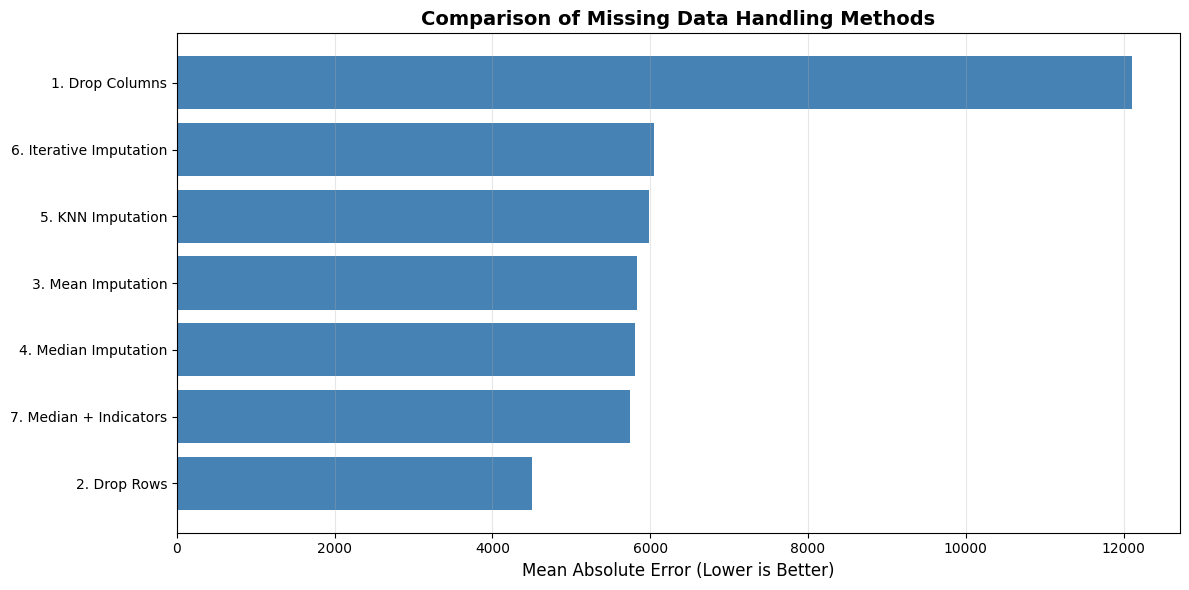

📊 Chart displayed above


In [ ]:
plt.figure(figsize=(12, 6))
plt.barh(results_df['Method'], results_df['MAE'], color='steelblue')
plt.xlabel('Mean Absolute Error (Lower is Better)', fontsize=12)
plt.title('Comparison of Missing Data Handling Methods', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 Chart displayed above")

---

# Practical Decision Guide for Future Projects

## Quick Decision Tree

### 1. START HERE: Check missing data percentage
- **<5% missing + large dataset** → Drop Rows
- **>70% missing in specific columns** → Drop Columns

### 2. FOR QUICK PROTOTYPES:
- Use **Median Imputation** (robust to outliers)
- Fast to implement, decent performance

### 3. FOR PRODUCTION MODELS:
- Try **KNN or Iterative Imputation**
- Better accuracy, worth the extra computation time

### 4. IF MISSINGNESS IS MEANINGFUL:
- Use **Imputation + Missing Indicators**
- Example: People not reporting income might be a signal

### 5. ALWAYS REMEMBER:
- ✅ Fit imputer on TRAINING data only
- ✅ Transform both train and validation with same imputer
- ✅ Test multiple methods - one size doesn't fit all!

### 6. DATASET-SPECIFIC FACTORS:
- **Correlated features** → KNN or Iterative work best
- **Independent features** → Simple imputation sufficient
- **Outliers present** → Use Median over Mean
- **Time/speed matters** → Simple imputation
- **Accuracy critical** → Iterative imputation

---

# Next Steps

1. **Apply the best method** to your actual dataset
2. **Monitor model performance** over time
3. **Investigate WHY data is missing** (may reveal insights)
4. **Consider domain-specific imputation** strategies if available
5. **Document your choice** for future reference

---

## Template Code for Your Project

Once you've determined the best method, use this template:

```python
# Load your data
df = pd.read_csv('your_data.csv')

# Split features and target
y = df['target_column']
X = df.drop(['target_column'], axis=1)

# Split train/validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.8, random_state=42
)

# Apply your chosen imputation method
from sklearn.impute import SimpleImputer  # or KNNImputer, IterativeImputer

imputer = SimpleImputer(strategy='median')  # adjust as needed
X_train_imputed = imputer.fit_transform(X_train)
X_valid_imputed = imputer.transform(X_valid)

# Train your model
model = YourModel()
model.fit(X_train_imputed, y_train)
```